# Importing the Necessary library

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D, Flatten, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/R&D dataset/data set/B. Disease Grading"

ls: cannot access '/content/drive/My Drive/R&D dataset/data set/B. Disease Grading': No such file or directory


In [ ]:
# Define functions to load images and labels
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder, filename), target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
    return np.array(images)

def load_labels_from_csv(file_path):
    df = pd.read_csv(file_path)
    return df['Risk of macular edema '].values  # Use the correct column name here

# Loading the Dataset

In [ ]:
#Load image from the dataset
train_data_dir= '/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/1. Original Images/a. Training Set'
test_data_dir = '/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/1. Original Images/b. Testing Set'

In [ ]:
train_csv_path ='/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
test_csv_path ='/content/drive/MyDrive/R&D IDRiD Dataset /B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

#Read train and test CSV files with specific columns
train_df = pd.read_csv(train_csv_path, usecols=['Image name', 'Risk of macular edema '])
test_df = pd.read_csv(test_csv_path, usecols=['Image name', 'Risk of macular edema '])

# Convert 'Risk of macular edema' column to string type
train_df['Risk of macular edema '] = train_df['Risk of macular edema '].astype(str)
test_df['Risk of macular edema '] = test_df['Risk of macular edema '].astype(str)

train_df['Image name'] = train_df['Image name'].astype(str)+ '.jpg'
test_df['Image name'] = test_df['Image name'].astype(str)+ '.jpg'

In [ ]:
#@title Image Read Function

#define function to read images and labels messidor dataset
def read_images_and_labels(data_path, annotation_df):
    data = []
    for index, row in annotation_df.iterrows():
        image_name = row['Image name']
        label = row['Risk of macular edema ']
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path)  # assuming in open cv compatible format
        image = cv2.resize(image, (224, 224))
        data.append([image, label])
    return data

In [ ]:
# Read images and labels using DataFrames
data13 = read_images_and_labels(train_data_dir, train_df)
data14 = read_images_and_labels(test_data_dir, test_df)

# Combine data
data = data13 + data14

print("data reading done")

data reading done


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, Flatten, Dense, BatchNormalization,Dropout,GlobalAveragePooling2D,Concatenate,Input,Add
from tensorflow.keras.activations import relu, softmax,elu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import zipfile
from sklearn.metrics import precision_score, recall_score
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical# used for categorical hot coding

In [ ]:
np.random.shuffle(data)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
X= []
y=[]

for features, label in data:
  X.append(features)
  y.append(label)

X = np.array(X)
y = np.array(y)
# out = np.divide(X,255)

# y= to_categorical(y, num_classes =3)

# Stratified splitting for train-test split
n_splits = 1
test_size = 0.2
stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=43)

In [ ]:
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Further split training data into training and validation sets
for train_index, val_index in stratified_split.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]

In [ ]:
# Check classwise distribution in train, test, and validation sets
unique_classes = np.unique(np.concatenate((y_train, y_test, y_val)))
for class_label in unique_classes:
    print(f"Class {class_label}:")
    print(f"Train: {np.sum(y_train == class_label)} images")
    print(f"Test: {np.sum(y_test == class_label)} images")
    print(f"Validation: {np.sum(y_val == class_label)} images")
    print('.........')

Class 0:
Train: 141 images
Test: 45 images
Validation: 36 images
.........
Class 1:
Train: 33 images
Test: 10 images
Validation: 8 images
.........
Class 2:
Train: 155 images
Test: 49 images
Validation: 39 images
.........


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, Flatten, Dense, BatchNormalization,Dropout,GlobalAveragePooling2D,Concatenate,Input,Add
from keras.utils import to_categorical
train_labels = to_categorical(y_train, num_classes=3)
val_labels = to_categorical(y_val, num_classes=3)
test_labels_one_hot = to_categorical(y_test, num_classes=3)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

input_layer=Input(shape=(224, 224, 3))

# BLOCK 1
x=Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu',)(input_layer)
x=BatchNormalization()(x)
x=MaxPooling2D((2, 2))(x)
x1=Conv2D(4, (7, 7), strides=(2, 2),padding='same',activation='relu',)(input_layer)
x1=Conv2D(16, (5, 5), strides=(1, 1), padding='same', activation='relu')(x1)
concatenated = Concatenate()([x1, x])


# BLOCK 2
x=(Conv2D(48, (3, 3), strides=(1, 1), padding='same', activation='relu'))(concatenated)
x=(BatchNormalization())(x)
x=(MaxPooling2D((2, 2)))(x)

# BLOCK 3
block3_output = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
block3_output= BatchNormalization()(block3_output)
block3_output = MaxPooling2D((2, 2))(block3_output)

# BLOCK 4
block4_output = Conv2D(80, (3, 3), strides=(1, 1), padding='same', activation='relu')(block3_output)
block4_output = BatchNormalization()(block4_output)
block4_output = Conv2D(40, (1, 1), strides=(1, 1), padding='same', activation='relu')(block4_output)
block4_output = Conv2D(80, (3, 3), strides=(1, 1), padding='same', activation='relu')(block4_output)
block4_output = BatchNormalization()(block4_output)

#Parallel Branch
#z= Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(block3_output)
#z=BatchNormalization()(z)
#z= Conv2D(40, (1, 1), strides=(1, 1), padding='same', activation='relu')(block3_output)
#z=BatchNormalization()(z)

# Concatenate Block 3 and Block 4 outputs
concatenated = Concatenate()([block3_output, block4_output])
x= MaxPooling2D((2, 2))(concatenated)

# BLOCK 5
x = Conv2D(96, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(48, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(96, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# DEPTH WISE CONV BLOCK 1
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
    #BLOCK 6
x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
    #BLOCK 7
   #Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu'),
  # BatchNormalization(),#- ADDED THIS AS WELL
    #DEPTH WISE CONV LAYER
    #DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu'),
    #Conv2D(96, (1, 1), strides=(1, 1), padding='same', activation='relu'),
    #Layer 8
    #Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'),
    #BatchNormalization(),
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)#--- ADDED THIS
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
#x = Dense(128,activation='relu')(x)
output_layer = Dense(3, activation='softmax')(x)

#
# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

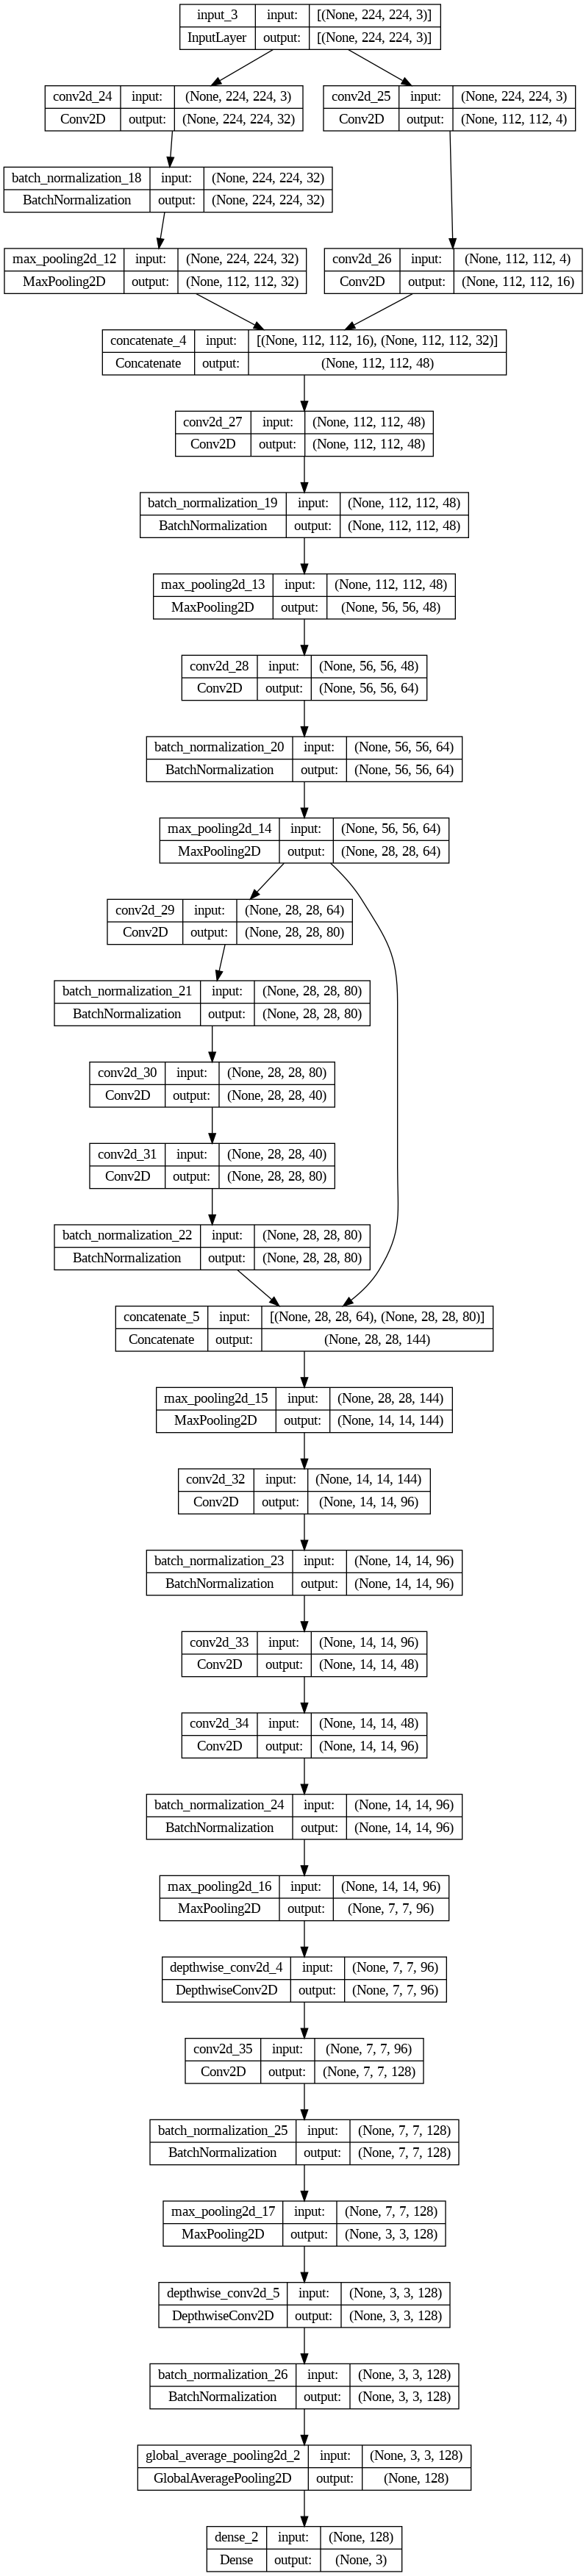

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model (model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 224, 224, 32)         896       ['input_3[0][0]']             
                                                                                                  
 conv2d_25 (Conv2D)          (None, 112, 112, 4)          592       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 224, 224, 32)         128       ['conv2d_24[0][0]']           
 tchNormalization)                                                                          

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Compile the model
# Define initial learning rate
# Compile the model (assuming 'model' is already defined as per your previous code)
initial_learning_rate = 0.0007
custom_optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=custom_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

def lr_schedule(epoch, lr):
    if epoch < 10:
        return initial_learning_rate
    else:
        return lr * 0.96

lr_scheduler = LearningRateScheduler(lr_schedule)
# Define LearningRateScheduler callback

# Define ReduceLROnPlateau callback
#reduce_lr = ReduceLROnPlateau(
#   monitor='val_loss',   # Metric to monitor
#    factor=0.96,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
#    patience=10,           # Number of epochs with no improvement after which learning rate will be reduced
#    min_lr=0.00001         # Lower bound on the learning rate


# Training the Model

In [ ]:
history = model.fit(X_train, train_labels, epochs=40, batch_size=10, validation_data=(X_val, val_labels),callbacks=[lr_scheduler])

Epoch 1/40
33/33 [==============================] - 11s 98ms/step - loss: 1.0023 - accuracy: 0.5562 - val_loss: 1.0382 - val_accuracy: 0.6145 - lr: 7.0000e-04
Epoch 2/40
33/33 [==============================] - 1s 27ms/step - loss: 0.8893 - accuracy: 0.6292 - val_loss: 1.0027 - val_accuracy: 0.4699 - lr: 7.0000e-04
Epoch 3/40
33/33 [==============================] - 1s 28ms/step - loss: 0.8770 - accuracy: 0.6049 - val_loss: 0.9794 - val_accuracy: 0.4819 - lr: 7.0000e-04
Epoch 4/40
33/33 [==============================] - 1s 28ms/step - loss: 0.7416 - accuracy: 0.6991 - val_loss: 0.9606 - val_accuracy: 0.5542 - lr: 7.0000e-04
Epoch 5/40
33/33 [==============================] - 1s 28ms/step - loss: 0.7128 - accuracy: 0.6991 - val_loss: 0.9503 - val_accuracy: 0.5904 - lr: 7.0000e-04
Epoch 6/40
33/33 [==============================] - 1s 28ms/step - loss: 0.7192 - accuracy: 0.7021 - val_loss: 0.9476 - val_accuracy: 0.4337 - lr: 7.0000e-04
Epoch 7/40
33/33 [==============================] -

In [ ]:
# Evaluate the model on testing set
test_loss, test_acc = model.evaluate(X_test, test_labels_one_hot)
print('Testing accuracy:', test_acc)

4/4 [==============================] - 0s 25ms/step - loss: 0.8418 - accuracy: 0.7596
Testing accuracy: 0.7596153616905212


In [ ]:
# Calculate precision and recall on training set
train_predictions = model.predict(X_train)
train_predictions = np.argmax(train_predictions, axis=1)
train_precision = precision_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
train_recall = recall_score(np.argmax(train_labels, axis=1), train_predictions, average='macro')
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)

11/11 [==============================] - 1s 26ms/step
Training Precision: 0.9976525821596244
Training Recall: 0.98989898989899


In [ ]:
# Calculate precision and recall on testing set
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_precision = precision_score(np.argmax(test_labels_one_hot, axis=1), test_predictions, average='macro')
test_recall = recall_score(np.argmax(test_labels_one_hot, axis=1), test_predictions, average='macro')
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)

4/4 [==============================] - 0s 20ms/step
Testing Precision: 0.6238905775075988
Testing Recall: 0.6122448979591837


# Visualization Starts!

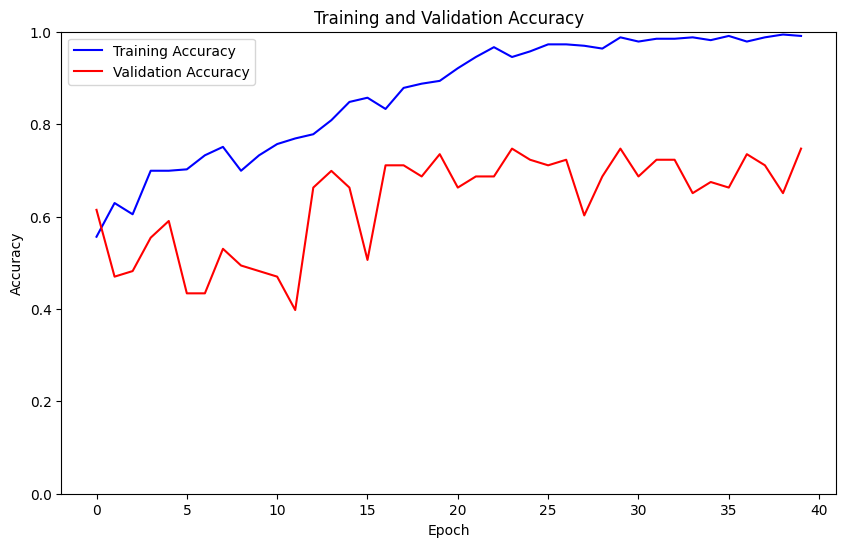

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

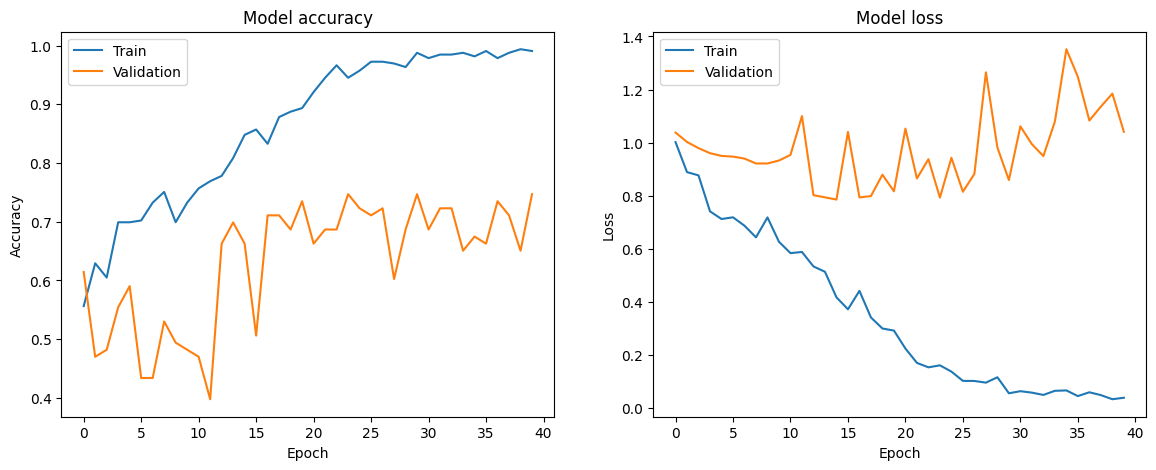

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


4/4 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

       DME 0       0.77      0.80      0.78        45
       DME 1       0.29      0.20      0.24        10
       DME 2       0.82      0.84      0.83        49

    accuracy                           0.76       104
   macro avg       0.62      0.61      0.62       104
weighted avg       0.75      0.76      0.75       104



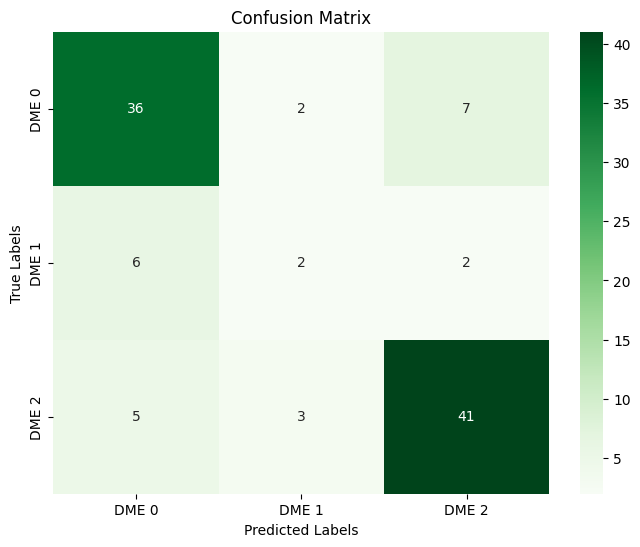

In [ ]:
import seaborn as sns
# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = ['DME 0', 'DME 1', 'DME 2']
report = classification_report(np.argmax(test_labels_one_hot, axis=1), y_pred_classes, target_names=class_names)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()